<a href="https://colab.research.google.com/github/andrea-mar/BBK_MScDataScience2reddit_posts/blob/main/reddit_Posts_sentiment_multiclass_SiEBERT_1epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code reference (code was adaptaed after this): https://www.youtube.com/watch?v=vNKIg8rXK6w&t=1492s&ab_channel=rupertai

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 14 20:02:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


Setup

In [3]:
# Install the transformers library
%%capture
%pip install datasets transformers==4.28.0
%pip install --upgrade accelerate
%pip install transformers
%pip install pytorch-lightning

Inspect data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [5]:
drive.mount('/content/drive', force_remount=False)

project_folder_path = '/content/drive/MyDrive/MS_DataSci_NLP_Reddit_project/'

train_file_name = f"{project_folder_path}data/data_sentiment/sentiment_data_train_sm.csv"
validation_file_name = f"{project_folder_path}data/data_sentiment/sentiment_data_val_sm.csv"
test_file_name = f"{project_folder_path}data/data_sentiment/sentiment_data_test_sm.csv"

Mounted at /content/drive


In [6]:
# read datasets
train_data = pd.read_csv(train_file_name)
val_data  = pd.read_csv(validation_file_name)
test_data = pd.read_csv(validation_file_name)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  623 non-null    int64 
 1   Document    623 non-null    object
 2   sentiment   623 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.7+ KB


In [8]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  156 non-null    int64 
 1   Document    156 non-null    object
 2   sentiment   156 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.8+ KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  156 non-null    int64 
 1   Document    156 non-null    object
 2   sentiment   156 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.8+ KB


In [10]:
train_data.sentiment.value_counts() # data is imbalanced -> ROC AUC and f1 bettter evaluation metrics

Neutral     397
Negative    142
Pozitive     84
Name: sentiment, dtype: int64

In [11]:
val_data.sentiment.value_counts()

Neutral     100
Negative     35
Pozitive     21
Name: sentiment, dtype: int64

In [12]:
test_data.sentiment.value_counts()

Neutral     100
Negative     35
Pozitive     21
Name: sentiment, dtype: int64

In [13]:
# convert categories into integers
from sklearn.preprocessing import LabelEncoder

# encode the sentiment classes as numbers
label_encoder = LabelEncoder()

# fit the label encoder on the training data and transform the sentiment column into numerical values
train_data['sentiment_encoded'] = label_encoder.fit_transform(train_data.sentiment)

# apply the same encoder to transform the sentiment column in the validation and test datasets
val_data['sentiment_encoded'] = label_encoder.transform(val_data.sentiment)
test_data['sentiment_encoded'] = label_encoder.transform(test_data.sentiment)


# get the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# print the mapping
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")


Class Mapping:
Negative: 0
Neutral: 1
Pozitive: 2


In [14]:
train_data.head(3)

,Unnamed: 0,Document,sentiment,sentiment_encoded
0,158,Mods can we consider a rule that says advocati...,Negative,0
1,397,If they don t have a BCBA then how d they get ...,Neutral,1
2,847,What is the replacement for ABA,Neutral,1


In [15]:
# drop the bool sentiment column
data_train = train_data.drop(columns=['sentiment'])
data_val = val_data.drop(columns=['sentiment'])
data_test = test_data.drop(columns=['sentiment'])
print('train data:\n',data_train.info(), '\n')
print('validation data:\n',data_val.info(), '\n')
print('test data:\n',data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         623 non-null    int64 
 1   Document           623 non-null    object
 2   sentiment_encoded  623 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.7+ KB
train data:
 None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         156 non-null    int64 
 1   Document           156 non-null    object
 2   sentiment_encoded  156 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.8+ KB
validation data:
 None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             -

In [16]:
data_train.shape, data_val.shape, data_test.shape

((623, 3), (156, 3), (156, 3))

In [17]:
data_train.sentiment_encoded.value_counts()

# Class Mapping:
# Negative: 0
# Neutral: 1
# Pozitive: 2

# most examples are neutral , data is imbalanced

1    397
0    142
2     84
Name: sentiment_encoded, dtype: int64

In [18]:
data_train.head(3)

,Unnamed: 0,Document,sentiment_encoded
0,158,Mods can we consider a rule that says advocati...,0
1,397,If they don t have a BCBA then how d they get ...,1
2,847,What is the replacement for ABA,1


In [19]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         623 non-null    int64 
 1   Document           623 non-null    object
 2   sentiment_encoded  623 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.7+ KB


In [20]:
data_val.sentiment_encoded.value_counts()

1    100
0     35
2     21
Name: sentiment_encoded, dtype: int64

In [21]:
data_test.sentiment_encoded.value_counts()

1    100
0     35
2     21
Name: sentiment_encoded, dtype: int64

In [22]:
attributes = {encoded_value: class_label for class_label, encoded_value in class_mapping.items()}
attributes

{0: 'Negative', 1: 'Neutral', 2: 'Pozitive'}

In [23]:
label_column = 'sentiment_encoded'

Data Set

DEEP LEARNING LLMs - SiEBERT - RoBERTa-large huggingface

Pipeline

Model to fine-tune : SiEBERT - RoBERTa / distilroberta

original RoBERTa article : https://arxiv.org/abs/1907.11692 <br>
original SiEBERT article: https://doi.org/10.1016/j.ijresmar.2022.05.005

huggingface:<br>
SiEBERT: https://huggingface.co/siebert/sentiment-roberta-large-english<br>
distilroberta: https://huggingface.co/distilroberta-base





In [24]:
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from transformers import pipeline

from sklearn.model_selection import train_test_split

In [25]:
# create a pytorch Dataset object containing tokenized and vectorized data
class Reddit_Dataset(Dataset):
  def __init__(self, data, tokenizer, label_column, max_token_len: int=512):
    self.data = data # dataframe (pandas)
    self.tokenizer = tokenizer # will use the model's AutoTokenizer
    self.label_column = label_column # class label : Negative: 0, Neutral: 1, Pozitive: 2
    self.max_token_len = max_token_len # 512 is the max tokens RoBERTa accepts (see original article above)


  def __len__(self):
    return(len(self.data))


  def __getitem__(self, index):
    item = self.data.iloc[index] # get the item in the dataframe at the given index
    text = str(item.Document) # get the text for that row and save it as a string
    label = torch.tensor(item[self.label_column], dtype=torch.long) # get the label as a tensor

    # tokenize the text (as PyTorch tensors)
    tokens = self.tokenizer.encode_plus(text,
                                        return_tensors='pt', # return pytorch tensors
                                        add_special_tokens=True, # adds special tokens like [CLS] and [SEP]
                                        truncation=True, # truncate the longer text
                                        max_length=self.max_token_len, # truncate the text to a max length of 512 tokens
                                        padding='max_length', # apply a padding to all text that is shorter that the max length (512)
                                        return_attention_mask=True)
    return {
        'input_ids': tokens.input_ids.flatten(),
        'attention_mask': tokens.attention_mask.flatten(),
        'labels': label
        }


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

# test the outputs of dataset
# model and tokenizer names
model_name = 'siebert/sentiment-roberta-large-english'

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)

trainset = Reddit_Dataset(data_train, tokenizer, label_column)
valset = Reddit_Dataset(data_val, tokenizer, label_column)
testset = Reddit_Dataset(data_test, tokenizer, label_column)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [30]:
# what the item (text representation  and labels) looks like as PyTorch tensors
trainset.__getitem__(0)

{'input_ids': tensor([    0, 48839,    64,    52,  1701,    10,  2178,    14,   161, 18060,
            50, 30066,    83,  3813,    16, 27686,  1993,  8134,   920,     8,
         15080,  2320,  1701,    24,     7,    28,   920,  2134,    85,    18,
         21468,     7,  5100,  1607,  5804,     8,  5741,     7, 24300, 33329,
            82,  1698,    83,  3813,  4570,  4395,    75,    28,  1220,    11,
            84,   435,   101,  1759,  2292, 20327,  1475,   748,  3631,  1178,
          4753,  1717,   295, 13749, 29126, 11613,   354,  2379,  8564,  1717,
           295, 13749, 49301,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [31]:
len(trainset), len(valset), len(testset)

(623, 156, 156)

Data module

In [32]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule
from typing import Optional

In [36]:
class Reddit_Data_Module(LightningDataModule):
    def __init__(
        self,
        traindata,
        valdata,
        testdata,
        label_column,
        model_name="roberta-base",  # default model name if not provided
        batch_size: int = 32,
        max_token_len: int=128,
        num_workers: int = 1, # number of cpus used
    ):
        super().__init__()

        # save hyperparameters ( this allows use of self.hparams.<hparam>)
        self.save_hyperparameters()
        self.traindata = traindata
        self.valdata=valdata
        self.testdata = testdata
        self.label_column = label_column

        # initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.hparams.model_name)

        # data transformations
        self.transforms = None

        # Initialize datasets as None
        self.data_train = None
        self.data_val = None
        self.data_test = None

    def setup(self, stage=None):
        if not self.data_train and not self.data_val:
            self.data_train = Reddit_Dataset(self.traindata, self.tokenizer, self.label_column)
            self.data_val = Reddit_Dataset(self.valdata, self.tokenizer, self.label_column)

        if stage == 'predict':
            print(stage)
            self.data_test = Reddit_Dataset(self.testdata, self.tokenizer, self.label_column)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            # pin_memory=self.hparams.pin_memory,
        )

In [37]:
reddit_module = Reddit_Data_Module(data_train, data_val, data_test, label_column, model_name=model_name)

In [38]:
reddit_module.setup()

In [39]:
dl = reddit_module.train_dataloader()

In [41]:
len(dl)

20

Model

In [42]:
from transformers import AutoModel, get_cosine_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [43]:
class Reddit_Classifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    # save and pass the parameters in a separate dict (makes it easier to change)
    self.config = config
    # get the pretrained model
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
    # append a classification layer to the pretrained model (2 layers to be have better performance: one hidden, one classification output)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    # initialize weights for the 2 layers
    torch.nn.init.xavier_uniform(self.hidden.weight)
    torch.nn.init.xavier_uniform(self.classifier.weight)
    # loss function
    # PyTorch documentation:
    # applying CrossEntropyLoss is equivalent to applying LogSoftmax on an input, followed by NLLLoss
    # a Softmax activation function is used for multiclass classification problems ( where the same data point can be in only class - classes are mutually exclusive)
    self.loss_function = nn.CrossEntropyLoss(reduction='mean')
    # create drop out layer to prevent overfitting
    self.dropout = nn.Dropout()


  def forward(self, input_ids, attention_mask, labels=None):
    # pretrained model
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    # get the output of the last hidden layer of the pretrained model
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # nn classification layers - feed the output of the pretrained model to the new layers we created
    pooled_output = self.hidden(pooled_output)  # new hidden layer
    pooled_output = self.dropout(pooled_output) # add dropout before the activation function (because we use relu this layer needs to be before - see AML lectures)
    pooled_output = F.relu(pooled_output) # add relu activation before the classification layer
    logits = self.classifier(pooled_output) # classification / final output layer
    # compute the loss
    loss = 0
    if labels is not None:
      loss = self.loss_function(logits, labels) # CrossEntropyLoss automatically applies softmax and computes the loss
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train loss', loss, prog_bar=True, logger=True)
    return {'loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('validation loss', loss, prog_bar=True, logger=True)
    return {'val_loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['batch_size']
    # warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = self.config['warmup']
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]

Train

In [44]:
# config = {
#     'model_name': 'siebert/sentiment-roberta-large-english',
#     'n_labels': len(attributes),
#     'batch_size': 4,
#     'lr': 1.5e-6,
#     'warmup': 0.2,
#     'train_size': len(reddit_module.train_dataloader()),
#     'w_decay': 0.001,
#     'n_epoch': 1 # test the asumption of the SiEBERT authors that the model can achieve around 70% accuracy after 1 epoch of training on a new small dataset
# }

# original hyperparameters used for fine tuning SiEBERT - https://huggingface.co/siebert/sentiment-roberta-large-english#fine-tuning-hyperparameters
config = {
    'model_name': 'siebert/sentiment-roberta-large-english',
    'n_labels': len(attributes),
    'batch_size': 4,
    'lr': 2e-5,
    'warmup': 500,
    'train_size': len(reddit_module.train_dataloader()),
    'w_decay': 0.01,
    'n_epoch': 1 # test the asumption of the SiEBERT authors that the model can achieve around 70% accuracy after 1 epoch of training on a new small dataset
}


In [45]:
# np.random.seed(7)
# model = Reddit_Classifier(config)

In [46]:
# # check the model is working on one case ( bug and output check )
# idx = 690
# input_ids = trainset.__getitem__(idx)['input_ids']
# att_mask = trainset.__getitem__(idx)['attention_mask']
# labels = trainset.__getitem__(idx)['labels']
# loss, output = model(input_ids.unsqueeze(dim=0), att_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))


In [47]:
# loss, output

Train

In [48]:
# from pytorch_lightning.callbacks import EarlyStopping

# # prevent overfitting
# # early stopping callback
# early_stopping_callback = EarlyStopping(
#     monitor='validation loss',  # metric to monitor
#     min_delta=0.001,  # min change in validation loss to be considered an improvement
#     patience=10,  # Nnumber of epochs with no improvement before stopping
#     verbose=True,
#     mode='min'  # 'min' because we want to minimize loss
# )

In [49]:
%%time
from pytorch_lightning import Trainer, seed_everything
torch.cuda.empty_cache()

seed_everything(42, workers=True)

# train module (includes the testdata but this is only used in the predict stage. Trainer will only use train and validation set)
train_module = Reddit_Data_Module(data_train, data_val, data_test, label_column, model_name=model_name, batch_size=config['batch_size'])
train_module.setup()

# model
model = Reddit_Classifier(config)

# train
trainer = pl.Trainer(
    max_epochs=config['n_epoch'],
    num_sanity_val_steps=2,
    accelerator="auto"
    # callbacks=[early_stopping_callback] this is not needed at for this training as in only trains for 1 epoch
    )

trainer.fit(model, train_module)

INFO:lightning_fabric.utilities.seed:Seed set to 42


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the model checkpoint at siebert/sentiment-roberta-large-english were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-43-7491fbcba90e>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.hidden.weight)
<ipython-input-43-7491fbcba90e>:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


CPU times: user 1min 6s, sys: 28.9 s, total: 1min 35s
Wall time: 1min 47s


In [50]:
# %load_ext tensorboard


In [51]:
# %tensorboard --logdir '/content/lightning_logs/version_0'

In [52]:
# !ls -l

In [53]:
# !lsof -i :6006


In [54]:
# !kill 8563

In [55]:
# from tensorboard import notebook
# notebook.list()

In [56]:
# notebook.display(port=6006, height=500)

In [57]:
# !tensorboard dev upload \
#   --logdir '/content/lightning_logs/version_0' \
#   --name 'ditilroberta finetuned' \
#   --description 'ditilroberta finetuned to reddit data' \
#   --one_shot

In [58]:
# import psutil
# print(f"Memory Usage: {psutil.virtual_memory()}")

In [59]:
# Save the trained model
trainer.save_checkpoint(f"{project_folder_path}models/Sentiment_SiEBERT_1epoch_original_param.ckpt")

Predict with model

In [60]:
# # method to convert list of text into predictions for each text
def classify_raw_text(model, dm, num_threads=1):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # set the number of CPU threads
  torch.set_num_threads(num_threads)

  predictions = trainer.predict(model, dm)
  # the sigmoin is used to squash the values in the range [0, 1]
  flatten_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flatten_predictions

In [61]:
try:
    predictions = classify_raw_text(model, train_module) # in the predict stage the train_module will use the test dataset (should heve used a better name?)
except Exception as e:
    print(f"An error occurred: {e}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TrainerFn.PREDICTING


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

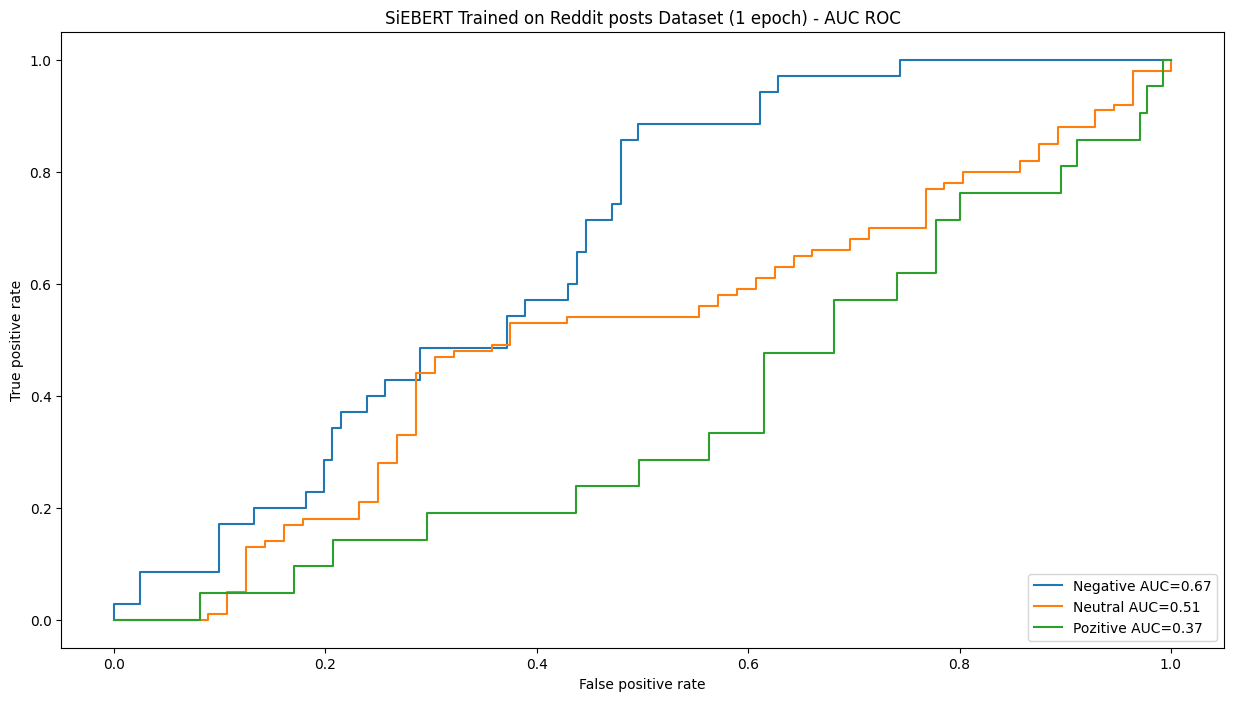

In [62]:
import matplotlib.pyplot as plt
from sklearn import metrics

test_data_labels = np.array(data_test[label_column])


plt.figure(figsize=(15, 8))

for i, attribute in enumerate(attributes.values()):
    # creates a binary array where elements are True if the corresponding element in test_data_labels is equal to i and False otherwise
    # one vs rest
    fpr, tpr, _ = metrics.roc_curve(
        (test_data_labels == i).astype(int), predictions[:, i]
    )
    auc = metrics.roc_auc_score(
        (test_data_labels == i).astype(int), predictions[:, i]
    )

    plt.plot(fpr, tpr, label=f'{attribute} AUC={auc:.2f}')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.title('SiEBERT Trained on Reddit posts Dataset (1 epoch) - AUC ROC')

plt.show()


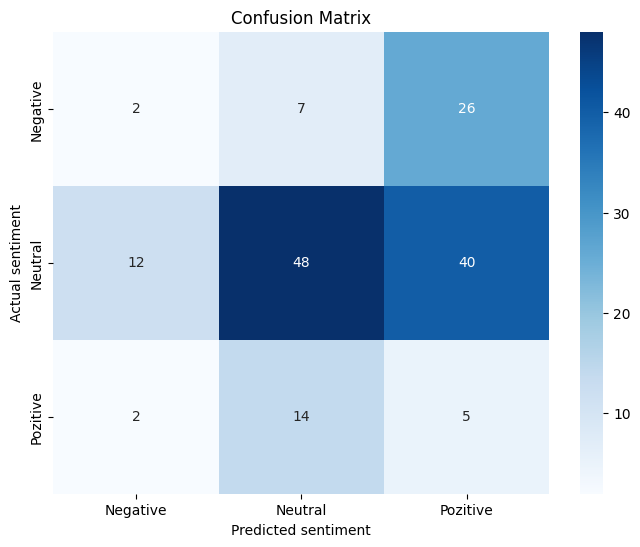

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# convert probabilities to class labels
predictions_labels = np.argmax(predictions, axis=1)

# create a confusion matrix
conf_matrix = confusion_matrix(test_data_labels, predictions_labels)

# get class names based on the dictionary
class_names = [attributes[i] for i in range(len(attributes))]

# plot confusion matrix for the test set using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted sentiment")
plt.ylabel("Actual sentiment")
plt.title("Confusion Matrix")
plt.show()


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

# convert probabilities to class labels
rounded_predictions = np.argmax(predictions, axis=1)

# accuracy score
accuracy = accuracy_score(test_data_labels, rounded_predictions)

# precision, recall, and F1 score (compute the weighted version for all metrics as this take into account the class imbalance/distribution)
precisions = precision_score(test_data_labels, rounded_predictions, average='weighted')
recalls = recall_score(test_data_labels, rounded_predictions, average='weighted')
f1_scores = f1_score(test_data_labels, rounded_predictions, average='weighted')
f2_scores = fbeta_score(test_data_labels, rounded_predictions, beta=2, average='weighted')

print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precisions}")
print(f"Recall:     {recalls}")
print(f"F1 Score:   {f1_scores}")
print(f"F2 Score:   {f2_scores}")

# classification report
class_report = classification_report(test_data_labels, rounded_predictions)
print("\nClassification Report:\n", class_report)

# f1=0.39 => the model performs very poorly after just one epoch of training
# this does not support the claim made in the paper (at least on this dataset)


Accuracy:   0.3526
Precision:  0.48345570917141645
Recall:     0.3525641025641026
F1 Score:   0.3963617978376827
F2 Score:   0.3641243231212122

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.06      0.08        35
           1       0.70      0.48      0.57       100
           2       0.07      0.24      0.11        21

    accuracy                           0.35       156
   macro avg       0.30      0.26      0.25       156
weighted avg       0.48      0.35      0.40       156



In [65]:
# the finetuned SiEBERT 1 epoch model ( using subreddits data )
print(model)

Reddit_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
       